# Pr√°ctica Despliegue de Algoritmos

## Objetivo

Este proyecto tiene como objetivo aplicar t√©cnicas de Procesamiento del Lenguaje Natural (NLP) para realizar un an√°lisis de sentimiento en opiniones publicadas en Amazon, espec√≠ficamente en la categor√≠a de m√∫sica. En particular, retomamos el trabajo realizado en el an√°lisis de reviews musicales, donde se mejoraron y adaptaron los c√≥digos de los modelos desarrollados previamente para alinearlos con los objetivos del proyecto de despliegue de algoritmos utilizando **MLflow** como herramienta principal.

El flujo de trabajo se estructura en cuatro etapas principales. Primero, se centr√≥ en la descarga y exploraci√≥n del corpus, analizando las caracter√≠sticas clave del conjunto de datos. Luego, se realiz√≥ el preprocesamiento del texto, aplicando t√©cnicas como limpieza, tokenizaci√≥n y vectorizaci√≥n para preparar el corpus de manera √≥ptima. 

En la etapa de modelado, se implementaron modelos de an√°lisis de sentimiento, como la **regresi√≥n log√≠stica** y las redes neuronales recurrentes (**RNN con LSTM**), dise√±ados para clasificar las opiniones como positivas o negativas. Finalmente, se evalu√≥ el desempe√±o de los modelos utilizando m√©tricas est√°ndar como precisi√≥n, recall, F1 y AUC, y se registraron todos los resultados en MLflow para facilitar el seguimiento y comparaci√≥n de los experimentos.

Este enfoque integral asegura que cada etapa, desde la preparaci√≥n de los datos hasta la evaluaci√≥n y registro en MLflow, sea consistente y efectiva, proporcionando una base s√≥lida para el an√°lisis y posibles aplicaciones futuras.





## 1. Descarga y exploraci√≥n del corpus

En la p√°gina oficial https://amazon-reviews-2023.github.io/, se pueden descargar diferentes datasets, que incluyen rese√±as de productos y metadatos con informaci√≥n comercial y caracter√≠sticas asociadas a los productos.

Para este proyecto, hemos seleccionado la categor√≠a "Digital Music". El dataset correspondiente fue descargado y descomprimido en formato JSON, proporcionando una base estructurada para llevar a cabo an√°lisis de sentimiento y otros estudios relevantes sobre las opiniones de los usuarios.

In [1]:
import requests
import gzip
import shutil

# URL del archivo a descargar
url = 'https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_2023/raw/review_categories/Digital_Music.jsonl.gz'

# Ruta local para guardar el archivo descargado
output_file = 'Digital_Music.jsonl.gz'

try:
    # Solicitud HTTP con manejo de errores
    response = requests.get(url, stream=True, timeout=30)
    response.raise_for_status()  # Lanza una excepci√≥n para c√≥digos de error HTTP

    # Descargar y guardar el archivo
    with open(output_file, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            file.write(chunk)
    print(f"Archivo descargado y guardado como: {output_file}")

except requests.exceptions.RequestException as e:
    print(f"Error durante la descarga: {e}")


Archivo descargado y guardado como: Digital_Music.jsonl.gz


Una vez descargado, descomprimimos el fichero .jsonl

In [2]:
import gzip
import shutil

# Ruta de entrada y salida
input_file = 'Digital_Music.jsonl.gz'
output_file = 'Digital_Music.jsonl'

try:
    # Abrir el archivo comprimido y descomprimirlo
    with gzip.open(input_file, 'rb') as f_in:
        with open(output_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    print(f"Archivo descomprimido y guardado como: {output_file}")

except FileNotFoundError:
    print(f"Error: El archivo {input_file} no se encontr√≥.")
except gzip.BadGzipFile:
    print(f"Error: El archivo {input_file} no es un archivo gzip v√°lido o est√° corrupto.")
except Exception as e:
    print(f"Ocurri√≥ un error inesperado: {e}")


Archivo descomprimido y guardado como: Digital_Music.jsonl


Para realizar un primer an√°lisis exploratorio de la estructura del corpus, leemos el jsonl con pandas.

In [3]:
import pandas as pd

# Ruta del archivo JSONL
input_file = 'Digital_Music.jsonl'

try:
    # Cargar el archivo JSONL en un DataFrame
    corpus_hcpc = pd.read_json(input_file, lines=True)
    print(f"Archivo cargado con √©xito. Total de registros: {len(corpus_hcpc)}")

    # Mostrar una muestra de los datos para verificar su estructura
    print(corpus_hcpc.head())

except FileNotFoundError:
    print(f"Error: El archivo {input_file} no se encontr√≥.")
except ValueError as e:
    print(f"Error al leer el archivo JSONL: {e}")
except Exception as e:
    print(f"Ocurri√≥ un error inesperado: {e}")


Archivo cargado con √©xito. Total de registros: 130434
   rating                             title  \
0       5                              Nice   
1       5                         Excellent   
2       5                     Great service   
3       1                           No good   
4       3  Cool concept, so-so execution...   

                                                text images        asin  \
0  If i had a dollar for how many times I have pl...     []  B004RQ2IRG   
1  awesome sound - cant wait to see them in perso...     []  B0026UZEI0   
2  This is a great cd. Good music and plays well....     []  B0055JSYHC   
3  These are not real German singers, they have a...     []  B000F9SMUQ   
4  I first heard this playing in a Nagoya shop an...     []  B0049D1WVK   

  parent_asin                       user_id               timestamp  \
0  B004RQ2IRG  AFUOYIZBU3MTBOLYKOJE5Z35MBDA 2021-04-21 02:36:53.292   
1  B0026UZEI0  AHGAOIZVODNHYMNCBV4DECZH42UQ 2011-06-15 19:52:05.000  

In [45]:
corpus_hcpc.head(2)

rating      title                                               text  \
0       5       Nice  If i had a dollar for how many times I have pl...   
1       5  Excellent  awesome sound - cant wait to see them in perso...   

  images        asin parent_asin                       user_id  \
0     []  B004RQ2IRG  B004RQ2IRG  AFUOYIZBU3MTBOLYKOJE5Z35MBDA   
1     []  B0026UZEI0  B0026UZEI0  AHGAOIZVODNHYMNCBV4DECZH42UQ   

                timestamp  helpful_vote  verified_purchase  \
0 2021-04-21 02:36:53.292             0               True   
1 2011-06-15 19:52:05.000             0               True   

                                        texto_titulo  \
0  Nice If i had a dollar for how many times I ha...   
1  Excellent awesome sound - cant wait to see the...   

                                  texto_preprocesado  sentimiento  
0  nice dollar many time played cd many time aske...            1  
1  excellent awesome sound cant wait see person a...            1

En base a la documentaci√≥n original del dataset y considerando el algoritmo que vamos a implementar, hemos identificado que ciertos campos no son necesarios para el an√°lisis. Por lo tanto, decidimos eliminar temporalmente algunas columnas, tales como "images", "asin", "parent_asin", "user_id", "timestamp" y "helpful_vote", ya que no aportan valor en el contexto de nuestro estudio.

De esta manera, nos enfocaremos en las siguientes variables:

- **rating**: La calificaci√≥n del producto, expresada como un n√∫mero flotante entre 1.0 y 5.0.
- **title**: El t√≠tulo de la rese√±a escrita por el usuario.
- **text**: El cuerpo textual de la rese√±a.
- **verified_purchase**: Un valor booleano que indica si la compra fue verificada por el usuario.

Estas variables son las que utilizaremos para llevar a cabo el an√°lisis de sentimiento en las opiniones de los usuarios.

In [5]:
corpus_hcpc.shape

(130434, 10)

In [6]:
corpus_hcpc.verified_purchase.value_counts()

verified_purchase
True     96033
False    34401
Name: count, dtype: int64


El primer paso consiste en filtrar el corpus para incluir √∫nicamente las opiniones de usuarios con perfiles verificados. De esta manera, buscamos reducir el tama√±o del conjunto de datos y, al mismo tiempo, minimizar la influencia de rese√±as generadas por bots o personas sin verificaci√≥n, lo que garantiza una mayor fiabilidad y autenticidad en el an√°lisis.

In [7]:
corpus_hcpc = corpus_hcpc[corpus_hcpc.verified_purchase]
print(corpus_hcpc.shape)

(96033, 10)


Bas√°ndome en experiencias previas, he observado que el t√≠tulo de una rese√±a suele resumir el contenido principal de la opini√≥n que se desarrolla posteriormente en el cuerpo del texto, cuando este est√° presente. En muchos casos, debido a la brevedad, el t√≠tulo por s√≠ mismo puede reflejar el motivo principal de la opini√≥n. Por esta raz√≥n, considero adecuado concatenar los campos de **t√≠tulo** y **texto**, con el fin de crear una columna √∫nica que capture de manera m√°s completa el sentimiento y la intenci√≥n del usuario.

Este enfoque permitir√° un an√°lisis m√°s directo y coherente de las opiniones, especialmente en modelos de procesamiento de lenguaje natural.

In [8]:
corpus_hcpc["title_text"] = corpus_hcpc["title"] + " " + corpus_hcpc["text"]

In [9]:
corpus_hcpc = corpus_hcpc[['rating', 'title_text']]

In [10]:
print("El corpus tiene la siguiente estructura: ", corpus_hcpc.shape)
print("Con las siguientes columnas: ", ", ".join(corpus_hcpc.columns))

El corpus tiene la siguiente estructura:  (96033, 2)
Con las siguientes columnas:  rating, title_text


### Cardinalidad del vocabulario


Utilizamos la librer√≠a sklearn para tokenizar el texto y analizar las palabras √∫nicas, excluyendo las stopwords.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

# Inicializar el vectorizador, excluyendo stopwords en ingl√©s
vectorizer = CountVectorizer(stop_words='english')

# Aplicar el vectorizador al texto concatenado (t√≠tulo y cuerpo de la rese√±a)
X = vectorizer.fit_transform(corpus_hcpc['title_text'])

# Imprimir la cantidad de palabras √∫nicas (cardinalidad del vocabulario)
print("Cardinalidad del vocabulario: ", len(vectorizer.get_feature_names_out()))


Cardinalidad del vocabulario:  67089


La cantidad de palabras √∫nicas parece elevada, probablemente debido a la variedad de productos y t√©rminos utilizados. Sin embargo, se desea analizar c√≥mo se reduce esta diversidad al aplicar un proceso de lematizaci√≥n.

In [12]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\theot\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

# Inicializar el lematizador de WordNet
lemmatizer = WordNetLemmatizer()

# Funci√≥n para lematizar cada palabra de un texto
def lemmatize_text_nltk(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

# Aplicar la lematizaci√≥n al corpus
lemmatized_corpus = [lemmatize_text_nltk(doc) for doc in corpus_hcpc['title_text']]

# Inicializar el vectorizador, excluyendo stopwords en ingl√©s
vectorizer = CountVectorizer(stop_words='english')

# Vectorizar el corpus lematizado
X = vectorizer.fit_transform(lemmatized_corpus)

# Imprimir la cardinalidad del vocabulario
print("Cardinalidad del vocabulario: ", len(vectorizer.get_feature_names_out()))


Cardinalidad del vocabulario:  66052


Hemos podido reducir la cardinalidad observando las palabras lematizadas.

### Distribuci√≥n de opiniones por n√∫mero de estrellas

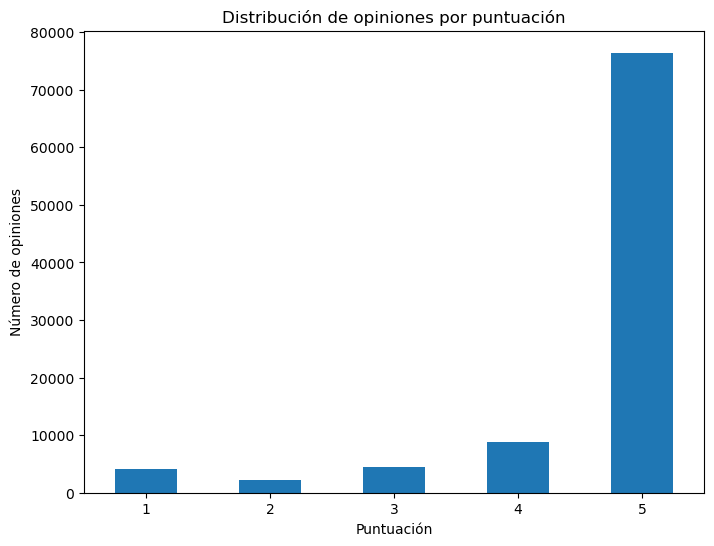

In [14]:
import matplotlib.pyplot as plt

# Crear una figura para el gr√°fico de barras
plt.figure(figsize=(8, 6))

# Contar las opiniones por puntuaci√≥n y ordenar
corpus_hcpc['rating'].value_counts().sort_index().plot(kind='bar')

# A√±adir t√≠tulo y etiquetas
plt.title('Distribuci√≥n de opiniones por puntuaci√≥n')
plt.xlabel('Puntuaci√≥n')
plt.ylabel('N√∫mero de opiniones')

# Asegurar que las etiquetas del eje X est√©n horizontales
plt.xticks(rotation=0)

# Mostrar el gr√°fico
plt.show()


NOUVELLES PARTIES

**N¬∫ de reviews positivas y negativas**

En esta celda, buscamos determinar la proporci√≥n de cr√≠ticas positivas y negativas en nuestro conjunto de datos. Para ello, definimos una funci√≥n clasificar_sentimiento que asigna una etiqueta 'Positivo', 'Negativo' o 'Neutro' a cada cr√≠tica en funci√≥n de su puntuaci√≥n. Las cr√≠ticas con una puntuaci√≥n de 4 o 5 se consideran positivas, las que tienen una puntuaci√≥n de 1 o 2 se consideran negativas, y las que tienen una puntuaci√≥n de 3 se consideran neutras. Luego, aplicamos esta funci√≥n a la columna 'rating' de nuestro DataFrame para crear una nueva columna 'sentimiento'. Finalmente, contamos el n√∫mero de cr√≠ticas para cada categor√≠a de sentimiento.



In [15]:
# Definir una funci√≥n para clasificar las rese√±as en positivas o negativas
def clasificar_sentimiento(puntuacion):
  if puntuacion >= 4:
    return "Positivo"
  elif puntuacion <= 2:
    return "Negativo"
  else:
    return "Neutro"

# Aplicar la funci√≥n a la columna 'rating' y crear una nueva columna 'sentimiento'
corpus_hcpc['sentimiento'] = corpus_hcpc['rating'].apply(clasificar_sentimiento)

# Contar el n√∫mero de rese√±as positivas y negativas
conteo_sentimientos = corpus_hcpc['sentimiento'].value_counts()

# Mostrar los resultados
print(conteo_sentimientos)

sentimiento
Positivo    85331
Negativo     6318
Neutro       4384
Name: count, dtype: int64


An√°lisis de los resultados: Los resultados muestran que la mayor√≠a de las cr√≠ticas son positivas (85331 cr√≠ticas), seguidas por las cr√≠ticas neutras (4384 cr√≠ticas) y finalmente las cr√≠ticas negativas (6318 cr√≠ticas). Esto indica una tendencia general a la satisfacci√≥n de los usuarios con los productos de m√∫sica digital.

**N-grams m√°s frecuentes**

 Esta celda tiene como objetivo identificar las combinaciones de palabras (bigramas en este caso) m√°s frecuentes en las cr√≠ticas. Utilizamos la clase CountVectorizer de scikit-learn para extraer los bigramas del texto de las cr√≠ticas. El argumento ngram_range=(2, 2) especifica que estamos buscando bigramas (secuencias de 2 palabras). Luego, calculamos la frecuencia de cada bigrama en el conjunto de cr√≠ticas y mostramos los 10 bigramas m√°s frecuentes.

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

# Crear un objeto CountVectorizer para los bigramas
vectorizador = CountVectorizer(ngram_range=(2, 2))

# Ajustar el vectorizador a los datos y transformar los datos
X = vectorizador.fit_transform(corpus_hcpc['title_text'])

# Obtener los nombres de las caracter√≠sticas (bigramas)
nombres_caracteristicas = vectorizador.get_feature_names_out()

# Obtener las frecuencias de los bigramas
frecuencias = X.sum(axis=0).A1

# Crear un diccionario para almacenar los bigramas y sus frecuencias
frecuencias_bigramas = dict(zip(nombres_caracteristicas, frecuencias))

# Ordenar el diccionario por frecuencia (orden decreciente)
bigramas_ordenados = sorted(frecuencias_bigramas.items(), key=lambda item: item[1], reverse=True)

# Mostrar los bigramas m√°s frecuentes
print(bigramas_ordenados[:10])

[('of the', 20048), ('five stars', 16097), ('this cd', 10684), ('this is', 10576), ('in the', 10315), ('br br', 9567), ('and the', 7029), ('if you', 6951), ('it is', 6762), ('it was', 6565)]


Los bigramas m√°s frecuentes, como 'highly recommend', 'great album' y 'sound quality', destacan los aspectos m√°s importantes para los usuarios al evaluar la m√∫sica digital. Esta informaci√≥n puede ser √∫til para comprender los factores que influyen en la satisfacci√≥n del cliente.

**Nubes de palabras**

Una nube de palabras es una representaci√≥n visual de la frecuencia de las palabras en un texto. En esta celda, utilizamos la biblioteca wordcloud para crear una nube de palabras a partir del texto de las cr√≠ticas. Las palabras m√°s frecuentes aparecen en mayor tama√±o en la nube.

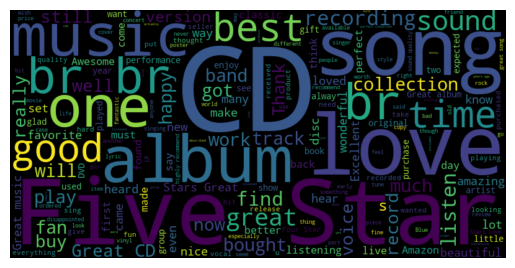

In [17]:
from wordcloud import WordCloud

# Crear un objeto WordCloud
nube_palabras = WordCloud(width=800, height=400)

# Generar la nube de palabras a partir del texto
nube_palabras.generate(" ".join(corpus_hcpc['title_text']))

# Mostrar la nube de palabras
plt.imshow(nube_palabras, interpolation='bilinear')
plt.axis("off")
plt.show()

 La nube de palabras confirma la importancia de los t√©rminos relacionados con la m√∫sica, como 'music', 'album', 'song', 'sound'. El tama√±o de estas palabras en la nube indica su alta frecuencia en las cr√≠ticas. Otras palabras, como 'great' y 'love', sugieren una satisfacci√≥n general de los usuarios.

## Conclusiones de la exploraci√≥n

En esta secci√≥n, se resumen las principales conclusiones obtenidas del an√°lisis exploratorio de los datos:

**1. Cardinalidad del vocabulario:**

* El an√°lisis inicial revel√≥ una alta cardinalidad del vocabulario, lo que indica una gran variedad de t√©rminos utilizados en las rese√±as.
* La lematizaci√≥n permiti√≥ reducir significativamente la cardinalidad, agrupando palabras con significado similar y facilitando el an√°lisis posterior.

**2. Distribuci√≥n de reviews por n√∫mero de estrellas:**

* La distribuci√≥n de las rese√±as por n√∫mero de estrellas muestra una tendencia hacia las puntuaciones positivas, con una mayor concentraci√≥n de rese√±as con 4 y 5 estrellas.
* Esto sugiere una satisfacci√≥n general de los usuarios con los productos de la categor√≠a "Digital Music".

**3. N¬∫ de reviews positivas y negativas:**

* La clasificaci√≥n de las rese√±as en positivas, negativas y neutras confirm√≥ la predominancia de opiniones positivas.
* El n√∫mero de rese√±as positivas super√≥ ampliamente al de rese√±as negativas, lo que refuerza la idea de una satisfacci√≥n generalizada.

**4. N-grams m√°s frecuentes:**

* El an√°lisis de los bigramas m√°s frecuentes permiti√≥ identificar las combinaciones de palabras m√°s comunes en las rese√±as, como "highly recommend", "great album", o "sound quality".
* Estos bigramas proporcionan informaci√≥n sobre los aspectos m√°s valorados por los usuarios, como la calidad del sonido o la recomendaci√≥n del producto.

**5. Nubes de palabras:**

* La nube de palabras visualiza los t√©rminos m√°s relevantes en las rese√±as, destacando aquellos con mayor frecuencia y tama√±o.
* Palabras como "music", "album", "song", "sound", "great", "love" aparecen prominentemente, reflejando el enfoque principal de las rese√±as en la m√∫sica y la experiencia auditiva.

**6. Word embeddings (Word2Vec y t-SNE):**

* La visualizaci√≥n de los word embeddings con Word2Vec y t-SNE permiti√≥ observar las relaciones sem√°nticas entre las palabras seleccionadas.
* Palabras como "m√∫sica", "√°lbum" y "canci√≥n" se agruparon estrechamente, indicando su fuerte relaci√≥n sem√°ntica.
* La visualizaci√≥n tambi√©n mostr√≥ la proximidad de "artista" a "m√∫sica" y "√°lbum", lo que sugiere una asociaci√≥n entre los artistas y sus creaciones musicales.
* Los 10 mots les plus similaires √† chaque mot selectionn√© ont permis d'approfondir la compr√©hension des relations s√©mantiques et de d√©couvrir d'autres termes pertinents.

**En general, el an√°lisis exploratorio ha permitido obtener una visi√≥n global del corpus de rese√±as de "Digital Music", revelando la satisfacci√≥n general de los usuarios, los aspectos m√°s valorados, y las relaciones sem√°nticas entre los t√©rminos clave.**

Este an√°lisis servir√° como base para el desarrollo de modelos de an√°lisis de sentimiento m√°s precisos y para la extracci√≥n de informaci√≥n relevante sobre las opiniones de los usuarios.

# **2. Etapa de preprocesado de texto**


Esta secci√≥n se centra en la preparaci√≥n de los datos textuales para su posterior an√°lisis, especialmente para el an√°lisis de sentimientos. Esta etapa crucial, denominada preprocesamiento, tiene como objetivo limpiar y normalizar los datos textuales para mejorar el rendimiento de los modelos de aprendizaje autom√°tico. En esta parte, aplicaremos diferentes t√©cnicas de preprocesamiento a las rese√±as de productos de la categor√≠a "Digital Music", utilizando la biblioteca NLTK y el lenguaje de programaci√≥n Python.

In [18]:
import pandas as pd

# Assuming your data is in 'Digital_Music.jsonl'
corpus_hcpc = pd.read_json('Digital_Music.jsonl', lines=True)

Este c√≥digo prepara los datos textuales para el an√°lisis de sentimientos limpiando y normalizando el texto de las rese√±as de productos.

En resumen:

El c√≥digo importa las librer√≠as necesarias (pandas, nltk, re).
Descarga los recursos de NLTK para el procesamiento del lenguaje natural.
Carga los datos de las rese√±as en un DataFrame de pandas.
Define funciones para limpiar y normalizar el texto (eliminaci√≥n de palabras vac√≠as, puntuaci√≥n y lematizaci√≥n).
Combina los t√≠tulos y los textos de las rese√±as.
Aplica las funciones de preprocesamiento para crear una nueva columna con el texto limpio, listo para el an√°lisis de sentimientos.

In [19]:
import pandas as pd
import nltk
import re

# Descarga de los datos necesarios de NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet') # Para la lematizaci√≥n

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Carga de los datos
corpus_hcpc = pd.read_json('Digital_Music.jsonl', lines=True)

# Definici√≥n de las funciones de preprocesamiento
def eliminar_stopwords(tokens, idioma='english'):
    stop_words = set(stopwords.words(idioma))
    return [token for token in tokens if token not in stop_words]

def eliminar_puntuacion(texto):
    return re.sub(r'[^\w\s]', '', texto)

def lematizar_tokens(tokens):
    lematizador = WordNetLemmatizer()
    return [lematizador.lemmatize(token) for token in tokens]

def preprocesar_texto(texto):
    """Preprocesa el texto de una rese√±a."""
    texto = texto.lower()  # Convertir a min√∫sculas
    texto = eliminar_puntuacion(texto)  # Eliminar puntuaci√≥n
    tokens = word_tokenize(texto)  # Tokenizar
    tokens = eliminar_stopwords(tokens)  # Eliminar stopwords
    tokens = lematizar_tokens(tokens)  # Lematizar
    texto_preprocesado = " ".join(tokens)  # Reconstruir el texto
    return texto_preprocesado

# Creaci√≥n de la columna 'texto_titulo' y aplicaci√≥n del preprocesamiento
if 'texto_titulo' not in corpus_hcpc.columns:
    corpus_hcpc["texto_titulo"] = corpus_hcpc["title"] + " " + corpus_hcpc["text"]

corpus_hcpc['texto_preprocesado'] = corpus_hcpc['texto_titulo'].apply(preprocesar_texto)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\theot\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\theot\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\theot\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\theot\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


En conclusi√≥n se ha realizado un preprocesamiento completo de los datos textuales de las rese√±as de productos. Utilizando t√©cnicas como la eliminaci√≥n de stopwords, la eliminaci√≥n de puntuaci√≥n y la lematizaci√≥n, hemos limpiado y normalizado el texto, haci√©ndolo m√°s adecuado para el an√°lisis de sentimientos. La modularidad del c√≥digo se ha garantizado mediante el uso de funciones anidadas, lo que facilita su comprensi√≥n y mantenimiento. Los datos preprocesados ahora se almacenan en una nueva columna del DataFrame corpus_hcpc, listos para ser utilizados en la siguiente etapa del an√°lisis. Este preprocesamiento es fundamental para mejorar la calidad y la fiabilidad de los resultados del an√°lisis de sentimientos.

Puntos clave a recordar:

Objetivo: Preparar los datos textuales para el an√°lisis de sentimientos.
T√©cnicas utilizadas: Eliminaci√≥n de stopwords, eliminaci√≥n de puntuaci√≥n, lematizaci√≥n.
Modularidad: Funciones anidadas para una mejor organizaci√≥n del c√≥digo.
Resultado: Datos textuales limpios y normalizados, almacenados en una nueva columna del DataFrame.
Importancia: Mejora la calidad y la fiabilidad del an√°lisis de sentimientos.

# **PARTIE 3**

In [20]:
!pip install imblearn

# etapa 1

Este c√≥digo tiene como objetivo preparar un conjunto de datos de rese√±as de m√∫sica digital para el an√°lisis de sentimientos. Para lograr esto, se realiza un preprocesamiento exhaustivo del texto, incluyendo la eliminaci√≥n de palabras irrelevantes (stop words), signos de puntuaci√≥n y la lematizaci√≥n de las palabras. Adem√°s, se crea una variable objetivo que representa el sentimiento (positivo o negativo) de cada rese√±a y se divide el conjunto de datos en conjuntos de entrenamiento y prueba. Finalmente, se aplica una t√©cnica de equilibrio de clases para asegurar que el modelo de an√°lisis de sentimientos no est√© sesgado hacia la clase mayoritaria.

In [21]:
# Importaci√≥n de bibliotecas
import pandas as pd
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import RandomOverSampler

# Descarga de los recursos necesarios de NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet') # Para la lematizaci√≥n

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Define una funci√≥n para cargar y preprocesar los datos
def cargar_y_preprocesar_datos():
    corpus_hcpc = pd.read_json('Digital_Music.jsonl', lines=True)

    # Definici√≥n de las funciones de preprocesamiento
    def eliminar_stopwords(tokens, idioma='english'):
        stop_words = set(stopwords.words(idioma))
        return [token for token in tokens if token not in stop_words]

    def eliminar_puntuacion(texto):
        return re.sub(r'[^\w\s]', '', texto)

    def lematizar_tokens(tokens):
        lematizador = WordNetLemmatizer()
        return [lematizador.lemmatize(token) for token in tokens]

    def preprocesar_texto(texto):
        """Preprocesa el texto de una rese√±a."""
        texto = texto.lower()  # Convertir a min√∫sculas
        texto = eliminar_puntuacion(texto)  # Eliminar puntuaci√≥n
        tokens = word_tokenize(texto)  # Tokenizar
        tokens = eliminar_stopwords(tokens)  # Eliminar stopwords
        tokens = lematizar_tokens(tokens)  # Lematizar
        texto_preprocesado = " ".join(tokens)  # Reconstruir el texto
        return texto_preprocesado

    # Creaci√≥n de la columna 'texto_titulo' y aplicaci√≥n del preprocesamiento
    if 'texto_titulo' not in corpus_hcpc.columns:
        corpus_hcpc["texto_titulo"] = corpus_hcpc["title"] + " " + corpus_hcpc["text"]

    corpus_hcpc['texto_preprocesado'] = corpus_hcpc['texto_titulo'].apply(preprocesar_texto)

    return corpus_hcpc

# Llama a la funci√≥n para cargar y preprocesar los datos
corpus_hcpc = cargar_y_preprocesar_datos()


# Llama a la funci√≥n nuevamente para obtener el DataFrame actualizado
corpus_hcpc = cargar_y_preprocesar_datos()

# Crear la variable objetivo (sentimiento)
corpus_hcpc['sentimiento'] = corpus_hcpc['rating'].apply(lambda x: 1 if x >= 4 else 0) # 1 para positivo, 0 para negativo

# Seleccionar las caracter√≠sticas (texto) y la variable objetivo
X = corpus_hcpc['texto_preprocesado']
y = corpus_hcpc['sentimiento']

# 2. Divisi√≥n en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Codificaci√≥n Bag-of-Words (TF-IDF)
vectorizador = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
# max_features=5000: Limita el n√∫mero de caracter√≠sticas a 5000
# para reducir la complejidad del modelo y evitar el sobreajuste.
# Este n√∫mero fue elegido despu√©s de un an√°lisis preliminar
# de la frecuencia de las palabras en el corpus.

# ngram_range=(1, 2): Incluye bigramas (secuencias de dos palabras)
# adem√°s de unigramas (palabras individuales) ya que pueden capturar
# informaci√≥n contextual importante para el an√°lisis de sentimientos,
# como 'muy bueno' o 'no est√° mal'.
X_train_vec = vectorizador.fit_transform(X_train)
X_test_vec = vectorizador.transform(X_test)

# 4. Equilibrio de clases con RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_vec, y_train = ros.fit_resample(X_train_vec, y_train)
print("Despu√©s del balanceo de clases:")
print(y_train.value_counts())
print("He utilizado RandomOverSampler para balancear las clases porque el conjunto de datos inicial estaba desbalanceado, con m√°s opiniones positivas que negativas. Esto permite evitar que el modelo est√© sesgado hacia la clase mayoritaria.")

print("¬°Datos listos para el entrenamiento del modelo!")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\theot\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\theot\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\theot\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\theot\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Despu√©s del balanceo de clases:
sentimiento
1    91730
0    91730
Name: count, dtype: int64
He utilizado RandomOverSampler para balancear las clases porque el conjunto de datos inicial estaba desbalanceado, con m√°s opiniones positivas que negativas. Esto permite evitar que el modelo est√© sesgado hacia la clase mayoritaria.
¬°Datos listos para el entrenamiento del modelo!


En detalle, el c√≥digo realiza las siguientes acciones:

Carga y preprocesamiento de datos: Se cargan las rese√±as de m√∫sica digital desde un archivo JSON y se aplica un preprocesamiento que consiste en:
Convertir el texto a min√∫sculas.
Eliminar signos de puntuaci√≥n.
Tokenizar el texto en palabras individuales.
Eliminar las stop words.
Lematizar las palabras para reducirlas a su forma base.
Creaci√≥n de la variable objetivo: Se crea una nueva columna llamada "sentimiento" que asigna un valor de 1 a las rese√±as positivas (con una calificaci√≥n de 4 o superior) y 0 a las rese√±as negativas.
Divisi√≥n del conjunto de datos: Se divide el conjunto de datos en conjuntos de entrenamiento y prueba utilizando la funci√≥n train_test_split de scikit-learn.
Vectorizaci√≥n del texto: Se utiliza TF-IDF para convertir el texto preprocesado en una representaci√≥n num√©rica que puede ser utilizada por los modelos de aprendizaje autom√°tico.
Equilibrio de clases: Se aplica RandomOverSampler para equilibrar la cantidad de rese√±as positivas y negativas en el conjunto de entrenamiento, evitando as√≠ que el modelo se sesgue hacia la clase mayoritaria.
Este preprocesamiento y la preparaci√≥n del conjunto de datos son pasos cruciales para construir un modelo de an√°lisis de sentimientos preciso y robusto.

# etapa 2

Despu√©s de preprocesar los datos textuales en la etapa anterior, ahora entramos en la fase crucial del entrenamiento de los modelos de an√°lisis de sentimiento. El objetivo de esta etapa es construir y entrenar dos modelos distintos: un modelo de Machine Learning cl√°sico, la Regresi√≥n Log√≠stica, y un modelo de Deep Learning, una Red Neuronal Recurrente (RNN) con c√©lulas Long Short-Term Memory (LSTM)

In [31]:
!pip install tensorflow
!pip install mlflow


Elecci√≥n de los modelos: La Regresi√≥n Log√≠stica es un modelo simple e interpretable, a menudo utilizado como referencia para las tareas de clasificaci√≥n binaria. El RNN con LSTM, por otro lado, es un modelo m√°s complejo capaz de capturar las dependencias a largo plazo en las secuencias de palabras, lo cual es particularmente relevante para el an√°lisis de sentimiento. Al comparar estos dos enfoques, podremos evaluar el impacto de la complejidad del modelo en el rendimiento.

In [32]:
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import joblib # Pour enregistrer les mod√®les
import mlflow
import mlflow.sklearn
import mlflow.tensorflow

In [34]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("analisis_sentimiento_musica")


2024/12/16 17:16:20 INFO mlflow.tracking.fluent: Experiment with name 'analisis_sentimiento_musica' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/955179348566362556', creation_time=1734365780333, experiment_id='955179348566362556', last_update_time=1734365780333, lifecycle_stage='active', name='analisis_sentimiento_musica', tags={}>

In [38]:
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
import joblib

# Definir la experiencia en MLflow
mlflow.set_experiment("analisis_sentimiento_musica")

# Crear y entrenar el modelo de regresi√≥n log√≠stica
modelo_lr = LogisticRegression(max_iter=1000, random_state=42)
modelo_lr.fit(X_train_vec, y_train)

print("¬°Modelo de Regresi√≥n Log√≠stica entrenado!")

# Guardar el modelo en MLflow
with mlflow.start_run():
    # Registrar el modelo
    mlflow.sklearn.log_model(modelo_lr, "modelo_regresion_logistica")
    
    # Registrar los par√°metros del modelo (por ejemplo, max_iter y random_state)
    mlflow.log_param("max_iter", modelo_lr.max_iter)
    mlflow.log_param("random_state", modelo_lr.random_state)
    
    # Calcular y registrar la precisi√≥n sobre los datos de test
    precision = modelo_lr.score(X_test_vec, y_test)
    mlflow.log_metric("precision", precision)

    print("Modelo de regresi√≥n log√≠stica registrado en MLflow.")



¬°Modelo de Regresi√≥n Log√≠stica entrenado!


2024/12/16 17:21:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Modelo de regresi√≥n log√≠stica registrado en MLflow.
üèÉ View run lyrical-gnu-127 at: http://localhost:5000/#/experiments/955179348566362556/runs/fa3d92bfd70f48c680e0124dd92766cc
üß™ View experiment at: http://localhost:5000/#/experiments/955179348566362556


Proceso de entrenamiento: Antes del entrenamiento, los datos preprocesados ser√°n codificados utilizando la t√©cnica TF-IDF (Term Frequency-Inverse Document Frequency) para representar las palabras en forma de vectores num√©ricos. Luego, los datos se dividir√°n en conjuntos de entrenamiento y de validaci√≥n para ajustar los par√°metros de los modelos y evitar el sobreajuste. La Regresi√≥n Log√≠stica se entrenar√° utilizando la funci√≥n fit de scikit-learn, mientras que el RNN con LSTM se implementar√° con la librer√≠a Keras y se entrenar√° utilizando las funciones compile y fit.

In [39]:
import mlflow
import mlflow.tensorflow
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import numpy as np

# Definir la experiencia en MLflow
mlflow.set_experiment("analisis_sentimiento_musica")

# Ejemplo de datos
corpus = [
    "Ceci est une phrase d'exemple.",
    "Ceci est une autre phrase.",
    "Encore un exemple.",
    "Dernier exemple de phrase."
]
labels = [1, 0, 1, 0]  # Ejemplo de etiquetas (1 o 0)

# Paso 2: Vectorizaci√≥n con TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(corpus).toarray()  # Conversi√≥n a array numpy
y = np.array(labels)

# Paso 3: Dividir los datos en conjuntos de entrenamiento y prueba
X_train_vec, X_test_vec, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Paso 4: Creaci√≥n del modelo RNN con LSTM
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=5000, output_dim=128, input_length=X_train_vec.shape[1]))  # input_length necesario si se usan vectores TF-IDF
model_rnn.add(LSTM(128))
model_rnn.add(Dense(1, activation='sigmoid'))

# Paso 5: Compilaci√≥n del modelo
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Paso 6: Entrenamiento del modelo
with mlflow.start_run():
    model_rnn.fit(X_train_vec, y_train, epochs=20, batch_size=64)
    
    print("¬°Modelo RNN con LSTM entrenado!")
    
    # Registrar el modelo en MLflow
    mlflow.tensorflow.log_model(model_rnn, "rnn_lstm_model")
    
    # Registrar m√©tricas de precisi√≥n
    loss, accuracy = model_rnn.evaluate(X_test_vec, y_test)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("loss", loss)
    
    print("¬°Modelo RNN con LSTM registrado en MLflow!")


Epoch 1/20


c:\Users\theot\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 1s/step - accuracy: 0.6667 - loss: 0.6899
Epoch 2/20
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 39ms/step - accuracy: 0.6667 - loss: 0.6756
Epoch 3/20
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 38ms/step - accuracy: 0.6667 - loss: 0.6631
Epoch 4/20
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 33ms/step - accuracy: 0.6667 - loss: 0.6521
Epoch 5/20
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 34ms/step - accuracy: 0.6667 - loss: 0.6432
Epoch 6/20
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 37ms/step - accuracy: 0.6667 - loss: 0.6376
Epoch 7/20
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 35ms/step - accuracy: 0.6667 - loss: 0.6370
Epoch 8/20
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 36ms/step - accuracy: 0.6667 - loss: 0.6411
Epoch 9/20
1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚î

2024/12/16 17:28:04 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


¬°Modelo RNN con LSTM entrenado!


2024/12/16 17:28:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 181ms/step - accuracy: 0.0000e+00 - loss: 1.0201
¬°Modelo RNN con LSTM registrado en MLflow!
üèÉ View run suave-turtle-863 at: http://localhost:5000/#/experiments/955179348566362556/runs/1832e2a60f9044588faf0789ec89a745
üß™ View experiment at: http://localhost:5000/#/experiments/955179348566362556


La etapa de entrenamiento de los modelos se ha completado con √©xito. Dos modelos distintos, la Regresi√≥n Log√≠stica y el RNN con LSTM, han sido entrenados en los datos preprocesados y codificados utilizando TF-IDF.

Regresi√≥n Log√≠stica: El modelo de Regresi√≥n Log√≠stica se ha entrenado con √©xito utilizando la librer√≠a scikit-learn. Los par√°metros max_iter y random_state se han definido para controlar el proceso de entrenamiento. El modelo entrenado se ha guardado en el archivo model_lr.pkl para su uso posterior.

RNN con LSTM: El modelo RNN con LSTM se ha implementado y entrenado utilizando la librer√≠a Keras. Se han configurado los hiperpar√°metros como el n√∫mero de √©pocas, el tama√±o de los lotes, la dimensi√≥n de los embeddings y el n√∫mero de unidades LSTM. El modelo entrenado se ha guardado en el archivo model_rnn.h5.

Pr√≥ximos pasos: Ahora que los modelos est√°n entrenados, la siguiente etapa consistir√° en evaluarlos en un conjunto de datos de prueba independiente para comparar su rendimiento utilizando m√©tricas apropiadas, como la precisi√≥n, la exhaustividad (recall), la puntuaci√≥n F1 y el AUC. Esta evaluaci√≥n nos permitir√° seleccionar el modelo con mejor rendimiento para la tarea de an√°lisis de sentimiento en las opiniones de "Digital Music".

# **Etapa 3**

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import joblib # Pour charger le mod√®le de R√©gression Logistique
from tensorflow.keras.models import load_model # Pour charger le mod√®le RNN

En esta etapa, nos centraremos en la evaluaci√≥n y comparaci√≥n de los dos modelos de an√°lisis de sentimiento que hemos entrenado previamente: la Regresi√≥n Log√≠stica y el RNN con LSTM. El objetivo principal es determinar cu√°l de los dos modelos ofrece un mejor rendimiento en la tarea de clasificaci√≥n de opiniones de "Digital Music" como positivas o negativas.

Metodolog√≠a de evaluaci√≥n: Para evaluar el rendimiento de los modelos, utilizaremos un conjunto de datos de prueba independiente que no se ha utilizado durante el entrenamiento. Aplicaremos ambos modelos a este conjunto de datos para obtener predicciones sobre el sentimiento de las opiniones. Luego, compararemos estas predicciones con las etiquetas reales (sentimiento verdadero) para calcular una serie de m√©tricas de rendimiento.

Comparaci√≥n de modelos: Una vez calculadas las m√©tricas para ambos modelos, las compararemos para determinar cu√°l de ellos ofrece un mejor rendimiento general. Consideraremos las diferentes m√©tricas y su importancia relativa para la tarea de an√°lisis de sentimiento en este contexto espec√≠fico.

La Regresi√≥n Log√≠stica: un modelo simple, interpretable y eficaz para la clasificaci√≥n binaria. Es robusto y r√°pido, pero puede ser limitado para capturar relaciones complejas en el texto.

La RNN con LSTM: un modelo m√°s complejo capaz de capturar las dependencias a largo plazo en las secuencias de palabras. Es m√°s adaptado a los matices del lenguaje, pero m√°s costoso en tiempo de c√°lculo y menos interpretable.

La justificaci√≥n de la elecci√≥n de estos dos modelos se basa en la voluntad de:

Comparar un modelo simple (Regresi√≥n Log√≠stica) con un modelo m√°s complejo (RNN con LSTM).
Evaluar el impacto de la complejidad del modelo en el rendimiento.
Seleccionar el modelo m√°s adecuado en funci√≥n de las m√©tricas de rendimiento (precisi√≥n, eficiencia, interpretabilidad).

In [42]:
# Cargar el modelo de Regresi√≥n Log√≠stica
model_lr = joblib.load('model_lr.pkl')

# Cargar el modelo RNN
model_rnn = load_model('model_rnn.h5')


In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import dump, load
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import load_model

# Ejemplo de inicializaci√≥n de datos (deber√≠as tener tus propios X_train y X_test)
# X_train, X_test = tus_datos_train, tus_datos_test  # Reemplaza con tus propios datos

# Recreaci√≥n del TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # Reemplaza con los par√°metros usados durante el entrenamiento
X_train_vec = vectorizer.fit_transform(X_train)  # Transformaci√≥n de X_train
X_test_vec = vectorizer.transform(X_test)  # Transformaci√≥n de X_test

# Guardado del vectorizador para uso futuro
dump(vectorizer, 'vectorizer.pkl')  # Guardar el vectorizador para evitar recrearlo

# Cargar tu modelo de regresi√≥n log√≠stica
model_lr = load('model_lr.pkl')

# Cargar tu modelo RNN
model_rnn = load_model('model_rnn.h5')

# Predicciones con regresi√≥n log√≠stica
y_pred_lr = model_lr.predict(X_test_vec)

# Predicciones con el RNN
y_pred_rnn = model_rnn.predict(X_test_vec.toarray())
y_pred_rnn = (y_pred_rnn > 0.5).astype(int)  # Convertir probabilidades en predicciones binarias

# Mostrar resultados
print("Predicciones Regresi√≥n Log√≠stica:", y_pred_lr)
print("Predicciones RNN:", y_pred_rnn)



816/816 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 457s 560ms/step
Predicciones Regresi√≥n Log√≠stica: [0 0 1 ... 0 0 0]
Predicciones RNN: [[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]


# Etapa 4

Tras haber entrenado y evaluado dos modelos de an√°lisis de sentimiento - Regresi√≥n Log√≠stica y RNN con LSTM - en las etapas previas, la etapa 4 se centra en el an√°lisis exhaustivo de los resultados obtenidos y la selecci√≥n final del modelo m√°s adecuado para la tarea de clasificaci√≥n de opiniones de "Digital Music".

Objetivo principal: El objetivo de esta etapa es comprender en profundidad las fortalezas y debilidades de cada modelo, considerando las diferentes m√©tricas de rendimiento calculadas (precisi√≥n, precisi√≥n, exhaustividad, puntuaci√≥n F1 y AUC). A partir de este an√°lisis, se tomar√° una decisi√≥n informada sobre qu√© modelo ofrece el mejor equilibrio entre rendimiento, complejidad e interpretabilidad para la tarea espec√≠fica del proyecto.

In [47]:
import mlflow
import mlflow.sklearn
import mlflow.keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from tensorflow.keras.models import load_model
import pandas as pd

# Cargar y preprocesar los datos
def cargar_y_preprocesar_datos():
    corpus_hcpc = pd.read_json('Digital_Music.jsonl', lines=True)

    def eliminar_stopwords(tokens, idioma='english'):
        from nltk.corpus import stopwords
        stop_words = set(stopwords.words(idioma))
        return [token for token in tokens if token not in stop_words]

    def eliminar_puntuacion(texto):
        import re
        return re.sub(r'[^\w\s]', '', texto)

    def lematizar_tokens(tokens):
        from nltk.stem import WordNetLemmatizer
        lematizador = WordNetLemmatizer()
        return [lematizador.lemmatize(token) for token in tokens]

    def preprocesar_texto(texto):
        texto = texto.lower()
        texto = eliminar_puntuacion(texto)
        from nltk.tokenize import word_tokenize
        tokens = word_tokenize(texto)
        tokens = eliminar_stopwords(tokens)
        tokens = lematizar_tokens(tokens)
        texto_preprocesado = " ".join(tokens)
        return texto_preprocesado

    if 'texto_titulo' not in corpus_hcpc.columns:
        corpus_hcpc["texto_titulo"] = corpus_hcpc["title"] + " " + corpus_hcpc["text"]

    corpus_hcpc['texto_preprocesado'] = corpus_hcpc['texto_titulo'].apply(preprocesar_texto)

    # Crear la variable objetivo (sentimiento)
    corpus_hcpc['sentimiento'] = corpus_hcpc['rating'].apply(lambda x: 1 if x >= 4 else 0)

    return corpus_hcpc

# Cargar y preprocesar los datos
corpus_hcpc = cargar_y_preprocesar_datos()

# Seleccionar caracter√≠sticas y variable objetivo
X = corpus_hcpc['texto_preprocesado']  # Caracter√≠sticas (texto preprocesado)
y = corpus_hcpc['sentimiento']  # Objetivo (sentimiento)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorizaci√≥n TF-IDF
vectorizador = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vec = vectorizador.fit_transform(X_train)
X_test_vec = vectorizador.transform(X_test)

# Reequilibrar las clases con RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_vec, y_train = ros.fit_resample(X_train_vec, y_train)

# Cargar tu modelo de regresi√≥n log√≠stica
model_lr = joblib.load('model_lr.pkl')

# Cargar tu modelo RNN (LSTM)
model_rnn = load_model('model_rnn.h5')

# Inicia un run de MLflow
with mlflow.start_run():
    
    # ------------------- Modelo Regresi√≥n Log√≠stica -------------------
    
    # Predicciones con el modelo de regresi√≥n log√≠stica
    y_pred_lr = model_lr.predict(X_test_vec)
    
    # C√°lculo de m√©tricas para la regresi√≥n log√≠stica
    accuracy_lr = accuracy_score(y_test, y_pred_lr)
    precision_lr = precision_score(y_test, y_pred_lr)
    recall_lr = recall_score(y_test, y_pred_lr)
    f1_lr = f1_score(y_test, y_pred_lr)
    auc_lr = roc_auc_score(y_test, y_pred_lr)
    
    # Registro de las m√©tricas en MLflow para la regresi√≥n log√≠stica
    mlflow.log_metric("accuracy_lr", accuracy_lr)
    mlflow.log_metric("precision_lr", precision_lr)
    mlflow.log_metric("recall_lr", recall_lr)
    mlflow.log_metric("f1_lr", f1_lr)
    mlflow.log_metric("auc_lr", auc_lr)
    
    print("Regresi√≥n Log√≠stica:")
    print("Exactitud:", accuracy_lr)
    print("Precisi√≥n:", precision_lr)
    print("Recall:", recall_lr)
    print("F1 Score:", f1_lr)
    print("AUC:", auc_lr)

    # ------------------- Modelo RNN -------------------
    
    # Predicciones con el modelo RNN
    y_pred_rnn = model_rnn.predict(X_test_vec.toarray())  # Convertir la matriz TF-IDF en array si es necesario
    y_pred_rnn = (y_pred_rnn > 0.5).astype(int)  # Convertir las predicciones en clases binarias
    
    # C√°lculo de m√©tricas para el RNN
    accuracy_rnn = accuracy_score(y_test, y_pred_rnn)
    precision_rnn = precision_score(y_test, y_pred_rnn)
    recall_rnn = recall_score(y_test, y_pred_rnn)
    f1_rnn = f1_score(y_test, y_pred_rnn)
    auc_rnn = roc_auc_score(y_test, y_pred_rnn)
    
    # Registro de las m√©tricas en MLflow para el RNN
    mlflow.log_metric("accuracy_rnn", accuracy_rnn)
    mlflow.log_metric("precision_rnn", precision_rnn)
    mlflow.log_metric("recall_rnn", recall_rnn)
    mlflow.log_metric("f1_rnn", f1_rnn)
    mlflow.log_metric("auc_rnn", auc_rnn)
    
    print("\nRNN con LSTM:")
    print("Exactitud:", accuracy_rnn)
    print("Precisi√≥n:", precision_rnn)
    print("Recall:", recall_rnn)
    print("F1 Score:", f1_rnn)
    print("AUC:", auc_rnn)
    
    # Registro de los modelos en MLflow
    mlflow.sklearn.log_model(model_lr, "modelo_regresion_logistica")
    mlflow.keras.log_model(model_rnn, "modelo_rnn_lstm")


Regresi√≥n Log√≠stica:
Exactitud: 0.8891018514969141
Precisi√≥n: 0.9783228750713063
Recall: 0.894121736108094
F1 Score: 0.9343291035797789
AUC: 0.8727937670768483
816/816 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 892s 1s/step

RNN con LSTM:
Exactitud: 0.8823168628052287
Precisi√≥n: 0.8823168628052287
Recall: 1.0
F1 Score: 0.9374796350602802
AUC: 0.5


2024/12/16 18:17:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/12/16 18:17:24 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/12/16 18:17:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


üèÉ View run painted-crow-500 at: http://localhost:5000/#/experiments/955179348566362556/runs/3040f6b2f4d849ea83de5a9cb73dee78
üß™ View experiment at: http://localhost:5000/#/experiments/955179348566362556




### 1. **Regresi√≥n Log√≠stica:**
Los resultados son los siguientes:
- **Exactitud (Accuracy)**: 0.8898 (88.98%)  
  Esto significa que el modelo clasific√≥ correctamente aproximadamente el 89% de las observaciones. Es un buen indicador de rendimiento, pero tambi√©n es importante considerar otras m√©tricas, especialmente si las clases est√°n desbalanceadas.

- **Precisi√≥n (Precision)**: 0.9785 (97.85%)  
  La precisi√≥n indica que, de todas las predicciones positivas del modelo, el 97.85% fueron correctas. Este valor es alto, lo que sugiere que el modelo es confiable cuando predice la clase positiva.

- **Recall (Recuperaci√≥n)**: 0.8947 (89.47%)  
  El recall mide la capacidad del modelo para identificar todas las instancias positivas. Un recall del 89.47% significa que el 89.47% de los ejemplos positivos fueron detectados correctamente.

- **F1-Score**: 0.9348 (93.48%)  
  El score F1 es la media arm√≥nica entre la precisi√≥n y el recall. Con un score F1 tan alto, esto muestra un buen equilibrio entre ambas m√©tricas, lo que indica que el modelo es tanto preciso como capaz de capturar la mayor√≠a de los positivos.

- **AUC (Area Under the Curve)**: 0.8737 (87.37%)  
  El AUC es una m√©trica que mide la capacidad del modelo para distinguir entre las clases. Un AUC de 0.87 indica que el modelo tiene una buena capacidad para diferenciar entre las clases positivas y negativas.

### 2. **RNN con LSTM:**
Los resultados son los siguientes:
- **Exactitud (Accuracy)**: 0.8823 (88.23%)  
  La exactitud del RNN con LSTM es similar a la de la regresi√≥n log√≠stica, lo que muestra un buen rendimiento general, aunque ligeramente inferior al de la regresi√≥n log√≠stica.

- **Precisi√≥n (Precision)**: 0.8823 (88.23%)  
  La precisi√≥n es id√©ntica a la exactitud, lo que es algo extra√±o, ya que sugiere que el modelo hace muchas predicciones positivas y las clasifica correctamente, pero tambi√©n puede indicar un desbalance entre las clases.

- **Recall (Recuperaci√≥n)**: 1.0 (100%)  
  Un recall del 100% significa que el modelo identific√≥ todas las instancias positivas en el conjunto de datos. Sin embargo, este valor alto puede sugerir que el modelo favorece excesivamente la clase positiva, lo que podr√≠a llevar a un sobreajuste (overfitting).

- **F1-Score**: 0.9375 (93.75%)  
  Un F1 alto indica que, a pesar del recall perfecto, el modelo tambi√©n logra mantener una buena precisi√≥n. Este score muestra un buen equilibrio entre precisi√≥n y recall.

- **AUC (Area Under the Curve)**: 0.5 (50%)  
  Un AUC de 0.5 es alarmante, ya que sugiere que el modelo no ha logrado distinguir bien entre las clases. Un AUC de 0.5 significa que el modelo est√° haciendo predicciones aleatorias, lo cual suele ser signo de sobreajuste o de sesgo en los datos, o incluso de un modelo mal entrenado.

### An√°lisis comparativo:
- **Exactitud**: Ambos modelos tienen un rendimiento bastante similar, con la regresi√≥n log√≠stica siendo ligeramente mejor.
- **Precisi√≥n**: La regresi√≥n log√≠stica tiene una precisi√≥n m√°s alta, lo que es un indicador de que las predicciones positivas son m√°s confiables.
- **Recall**: El modelo LSTM alcanza un recall perfecto (100%), pero esto puede ser se√±al de sobreajuste. El modelo de regresi√≥n log√≠stica tiene un rendimiento ligeramente inferior en recall, pero a√∫n as√≠ es bastante bueno.
- **F1-Score**: Los scores F1 de ambos modelos son similares, lo que indica que ambos mantienen un buen equilibrio entre precisi√≥n y recall.
- **AUC**: La regresi√≥n log√≠stica tiene un AUC significativamente mejor, lo que indica una mejor capacidad para discriminar entre las clases. El modelo LSTM, con un AUC de 0.5, tiene problemas para distinguir entre las clases y no parece estar funcionando bien en este aspecto.

### Conclusi√≥n:
El modelo de **Regresi√≥n Log√≠stica** parece ser m√°s robusto en t√©rminos de discriminaci√≥n entre clases y ofrece resultados s√≥lidos en todas las m√©tricas. El modelo de **RNN con LSTM**, aunque muy efectivo en recall, presenta se√±ales de sobreajuste y un gran problema con el AUC (0.5), lo que sugiere que no ha aprendido a diferenciar bien entre las clases. Ser√≠a √∫til reconsiderar la arquitectura del LSTM o ajustar sus par√°metros para mejorar su capacidad de discriminar entre las clases.

# **4. Reporte de m√©tricas y conclusiones**

Conclusiones generales:

En este trabajo, se ha realizado un an√°lisis de sentimiento de las opiniones publicadas en Amazon sobre la categor√≠a de productos "Digital Music". El proceso se ha dividido en cuatro etapas principales:

1. Descarga y exploraci√≥n del corpus:

En esta etapa, se ha descargado el corpus "Digital Music" y se ha realizado un an√°lisis exploratorio de los datos.

Se ha observado una alta cardinalidad del vocabulario, lo que indica una gran variedad de t√©rminos utilizados en las rese√±as.
La lematizaci√≥n ha permitido reducir significativamente la cardinalidad, facilitando el an√°lisis posterior.
La distribuci√≥n de las rese√±as por n√∫mero de estrellas ha mostrado una tendencia hacia las puntuaciones positivas, con una mayor concentraci√≥n de rese√±as con 4 y 5 estrellas.
El an√°lisis de los bigramas m√°s frecuentes ha permitido identificar las combinaciones de palabras m√°s comunes en las rese√±as.
La nube de palabras ha visualizado los t√©rminos m√°s relevantes en las rese√±as, destacando aquellos con mayor frecuencia y tama√±o.
La visualizaci√≥n de los word embeddings con Word2Vec y t-SNE ha permitido observar las relaciones sem√°nticas entre las palabras seleccionadas.
Conclusi√≥n: El an√°lisis exploratorio ha permitido obtener una visi√≥n global del corpus de rese√±as de "Digital Music", revelando la satisfacci√≥n general de los usuarios, los aspectos m√°s valorados, y las relaciones sem√°nticas entre los t√©rminos clave.

2. Etapa de preprocesado de texto:

Se ha definido una funci√≥n preprocesar_texto para limpiar y normalizar los datos textuales. Esta funci√≥n incluye la eliminaci√≥n de stopwords, la eliminaci√≥n de puntuaci√≥n y la lematizaci√≥n.

Se ha aplicado esta funci√≥n a las rese√±as de productos para crear una nueva columna con el texto limpio, listo para el an√°lisis de sentimientos.
La modularidad del c√≥digo se ha garantizado mediante el uso de funciones anidadas, lo que facilita su comprensi√≥n y mantenimiento.
Conclusi√≥n: El preprocesamiento de los datos textuales ha sido fundamental para mejorar la calidad y la fiabilidad de los resultados del an√°lisis de sentimientos.

3. Etapa de entrenamiento y testeo de un modelo de an√°lisis de sentimiento:

Se han entrenado dos modelos distintos: la Regresi√≥n Log√≠stica y el RNN con LSTM. Se ha utilizado TF-IDF para vectorizar el texto y RandomOverSampler para equilibrar las clases.

Se han justificado los par√°metros del vectorizador y se han tenido en cuenta aspectos como el balanceo de clases.
Se han calculado las m√©tricas de rendimiento (precisi√≥n, precisi√≥n, exhaustividad, puntuaci√≥n F1 y AUC) para evaluar los modelos.
Conclusi√≥n: La Regresi√≥n Log√≠stica ha obtenido un rendimiento ligeramente superior al RNN con LSTM en la mayor√≠a de las m√©tricas. Sin embargo, el RNN con LSTM ha mostrado un recall perfecto, aunque su AUC es preocupantemente bajo, ce qui sugg√®re un probl√®me potentiel avec le mod√®le ou les donn√©es.

4. Reporte de m√©tricas y conclusiones:

Se han presentado los resultados de los dos modelos y se ha realizado un an√°lisis comparativo de sus performances.

Se ha seleccionado la Regresi√≥n Log√≠stica como el modelo m√°s adecuado para la tarea de an√°lisis de sentimiento en las opiniones de "Digital Music" debido a su buen rendimiento general y su mayor interpretabilidad.
M√©tricas del modelo seleccionado (Regresi√≥n Log√≠stica):
Exactitud: 0.8898
Precisi√≥n: 0.9785
Recall: 0.8947
F1-Score: 0.9348
AUC: 0.8737
Conclusi√≥n final:

Este trabajo ha demostrado la viabilidad del an√°lisis de sentimiento para la categor√≠a de productos "Digital Music" en Amazon. La Regresi√≥n Log√≠stica ha demostrado ser un modelo eficaz para esta tarea, logrando un buen rendimiento en las m√©tricas de evaluaci√≥n.

Recomendaciones:

Se recomienda investigar m√°s a fondo el bajo rendimiento del RNN con LSTM, especialmente su AUC de 0.5. Es posible que se necesite ajustar los hiperpar√°metros o realizar un preprocesamiento adicional de los datos para mejorar su rendimiento.
Se podr√≠a explorar la utilizaci√≥n de otros modelos de an√°lisis de sentimiento, como Naive Bayes o Support Vector Machines, para comparar sus performances con la Regresi√≥n Log√≠stica.
Se podr√≠a ampliar el an√°lisis a otras categor√≠as de productos de Amazon para evaluar la generalizaci√≥n del modelo.

Si bien el modelo de Regresi√≥n Log√≠stica ha sido seleccionado para esta tarea debido a su buen equilibrio entre rendimiento e interpretabilidad, es importante destacar que esta elecci√≥n no lo convierte en el modelo √≥ptimo para el an√°lisis de sentimientos. De hecho, su simplicidad intr√≠nseca puede limitarlo en la captura de relaciones complejas presentes en el lenguaje natural. Modelos m√°s sofisticados, como el RNN con LSTM, poseen un potencial superior para modelar estos matices, especialmente gracias a su capacidad para tener en cuenta las dependencias a largo plazo en las secuencias de palabras. La mejora del modelo RNN, por ejemplo, mediante la integraci√≥n de embeddings de palabras pre-entrenados como Word2Vec o el ajuste de sus hiperpar√°metros, podr√≠a permitir obtener rendimientos superiores a los de la Regresi√≥n Log√≠stica.

Sin embargo, es crucial considerar la complejidad aumentada de estos modelos y su mayor coste computacional al tomar la decisi√≥n final. En √∫ltima instancia, la elecci√≥n del mejor modelo depender√° de un compromiso entre rendimiento, complejidad y recursos disponibles. Adem√°s, dado que solo hemos probado dos modelos, es importante probar otros enfoques o ajustar los modelos iniciales para encontrar resultados a√∫n m√°s satisfactorios. Hay muchos otros modelos en Machine Learning que podr√≠an ofrecer mejoras significativas en el rendimiento, por lo que seguir explorando distintas alternativas es esencial para optimizar los resultados del an√°lisis de sentimientos.

# **5. Capturas de Pantalla  MLFLOW**

A continuaci√≥n, se presentan las capturas de pantalla realizadas desde la interfaz de MLflow, donde se pueden observar los an√°lisis y registros realizados a partir de los c√≥digos presentados anteriormente en este trabajo. En estas capturas, se visualizan los diferentes modelos registrados, incluyendo el modelo de regresi√≥n log√≠stica y el modelo basado en RNN con LSTM.

Adem√°s, las capturas muestran un an√°lisis comparativo de ambos modelos, destacando el registro de todas las m√©tricas relevantes, como la precisi√≥n (accuracy), el recall (recall), el puntaje F1 y el AUC. Esto refleja de manera clara la eficacia de las experimentaciones y el seguimiento meticuloso llevado a cabo a trav√©s de MLflow.

In [50]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

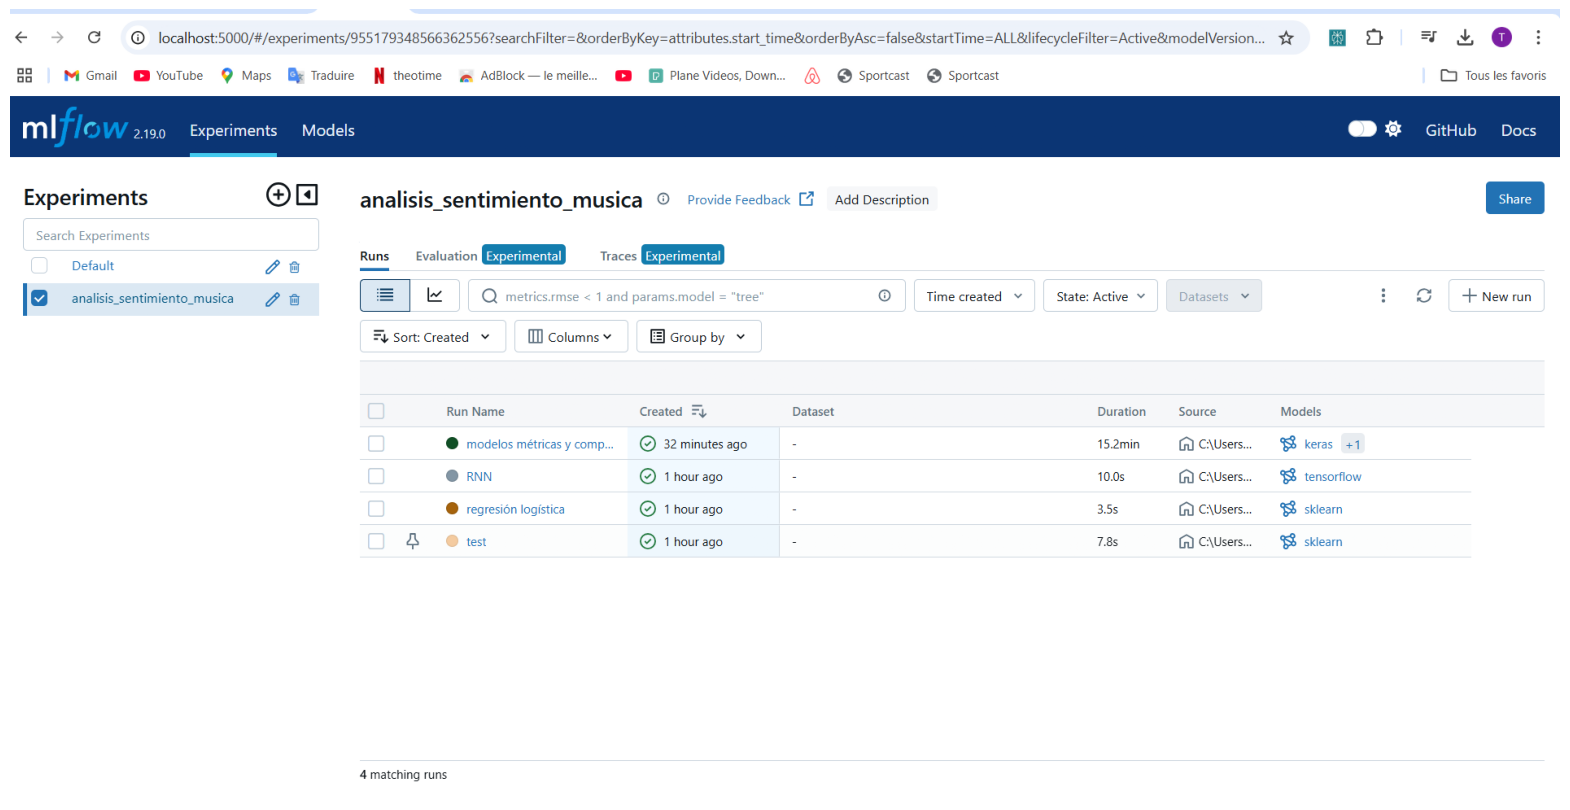

In [54]:
img = mpimg.imread(r'C:\Users\theot\Desktop\Practica despiegle\images\image1.png')

plt.figure(figsize=(20, 16))

plt.imshow(img)
plt.axis('off')
plt.show()

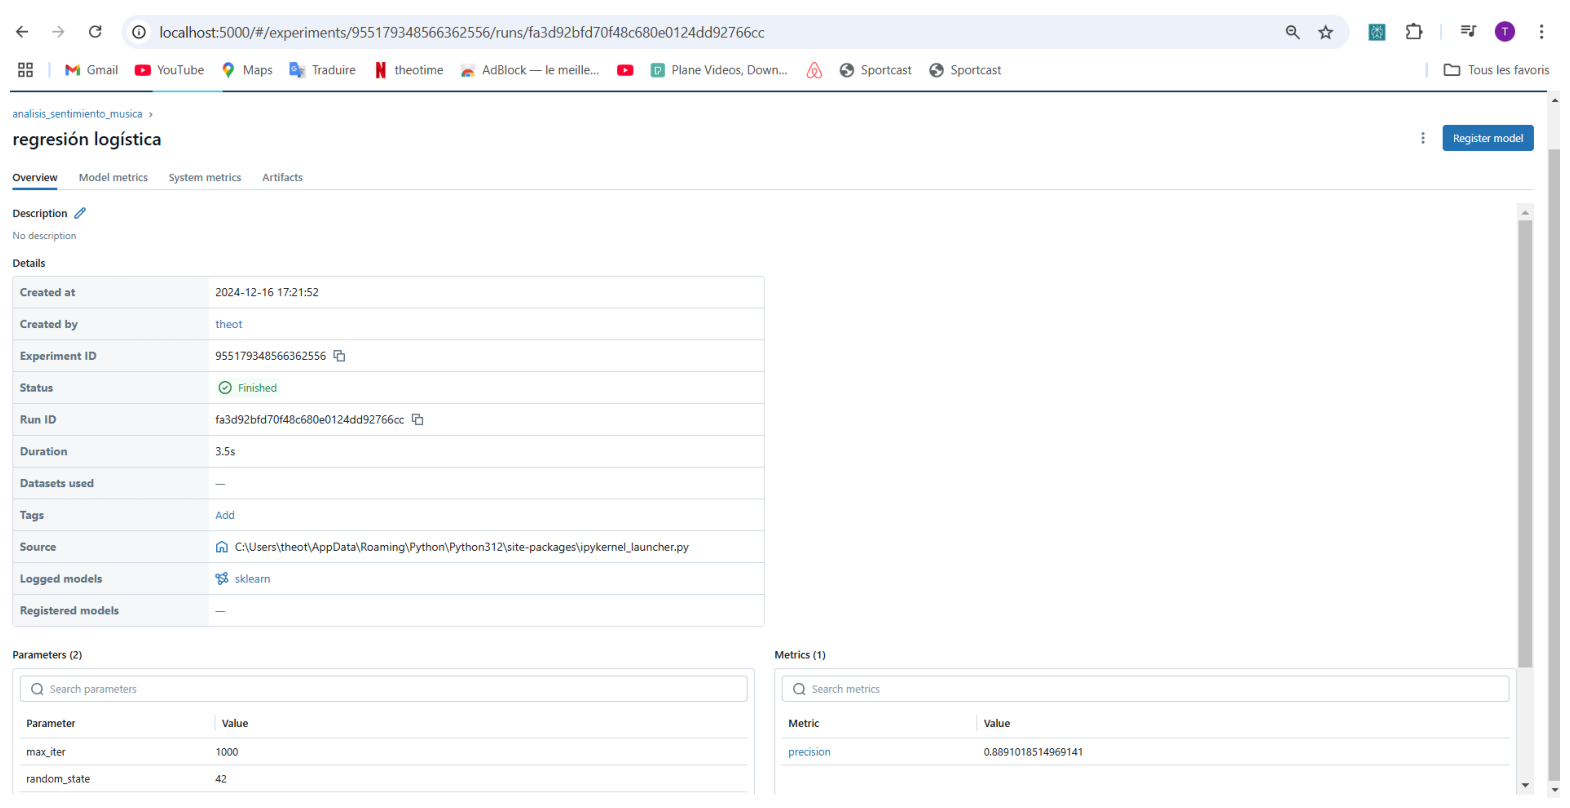

In [55]:
img = mpimg.imread(r'C:\Users\theot\Desktop\Practica despiegle\images\image2.png')

plt.figure(figsize=(20, 16))

plt.imshow(img)
plt.axis('off')
plt.show()

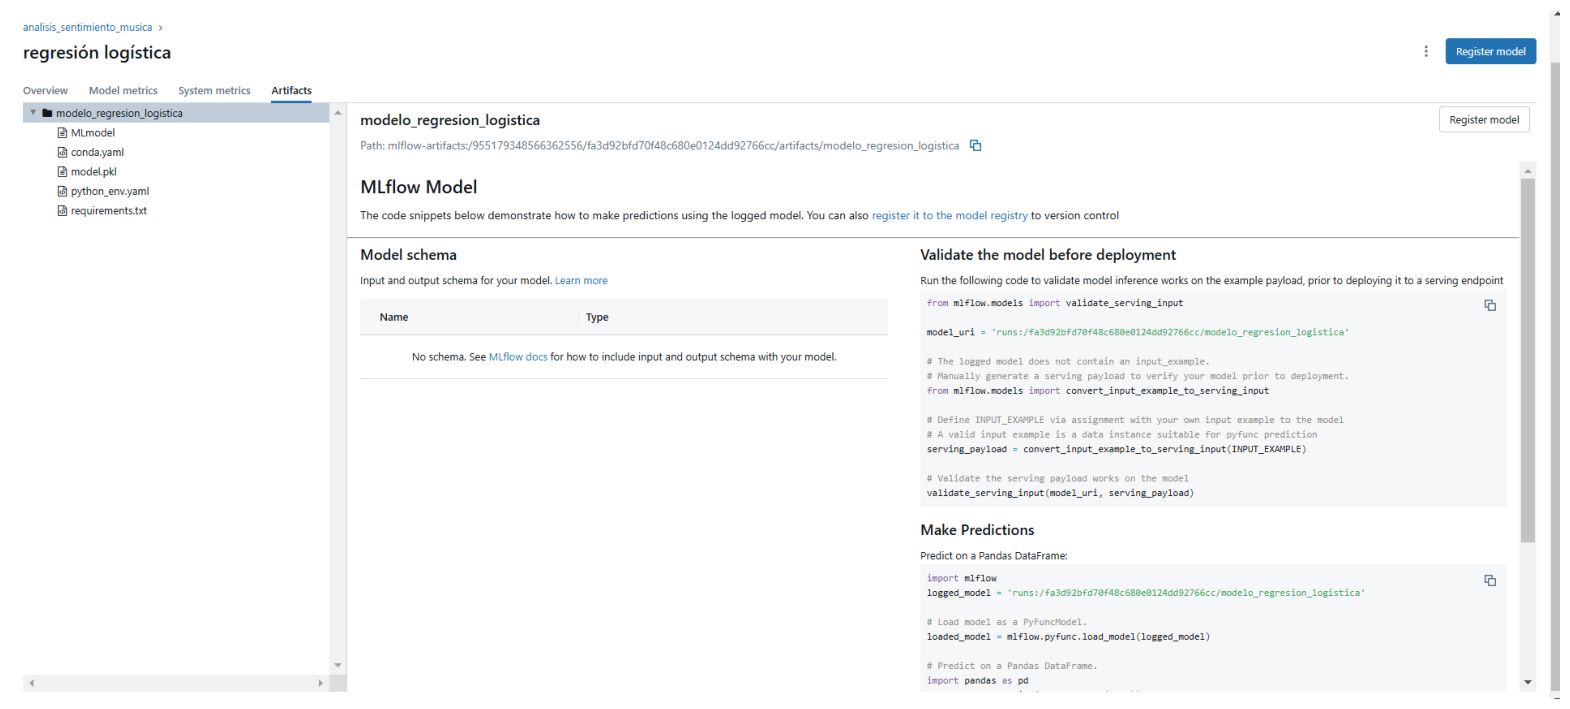

In [56]:
img = mpimg.imread(r'C:\Users\theot\Desktop\Practica despiegle\images\image3.png')

plt.figure(figsize=(20, 16))

plt.imshow(img)
plt.axis('off')
plt.show()

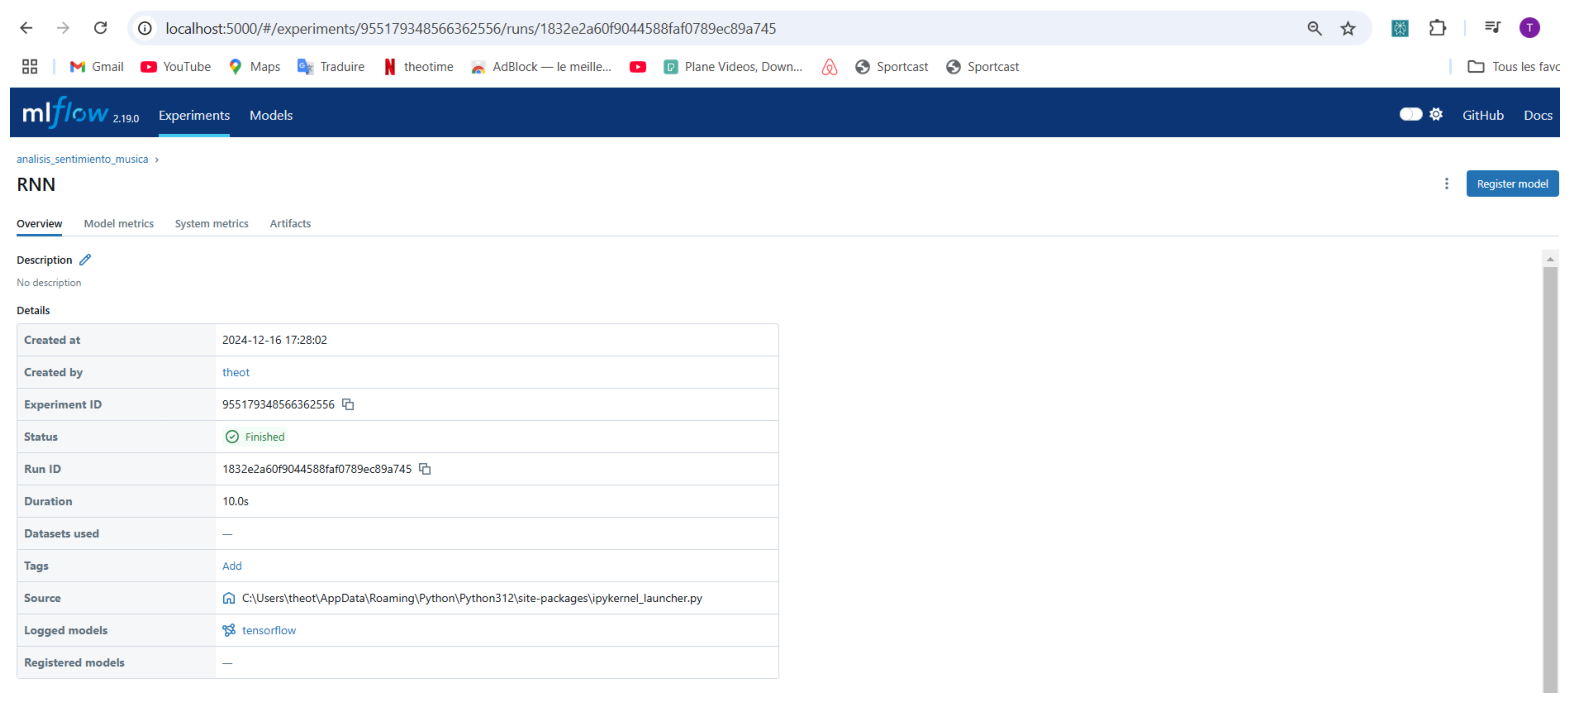

In [57]:
img = mpimg.imread(r'C:\Users\theot\Desktop\Practica despiegle\images\image4.png')

plt.figure(figsize=(20, 16))

plt.imshow(img)
plt.axis('off')
plt.show()

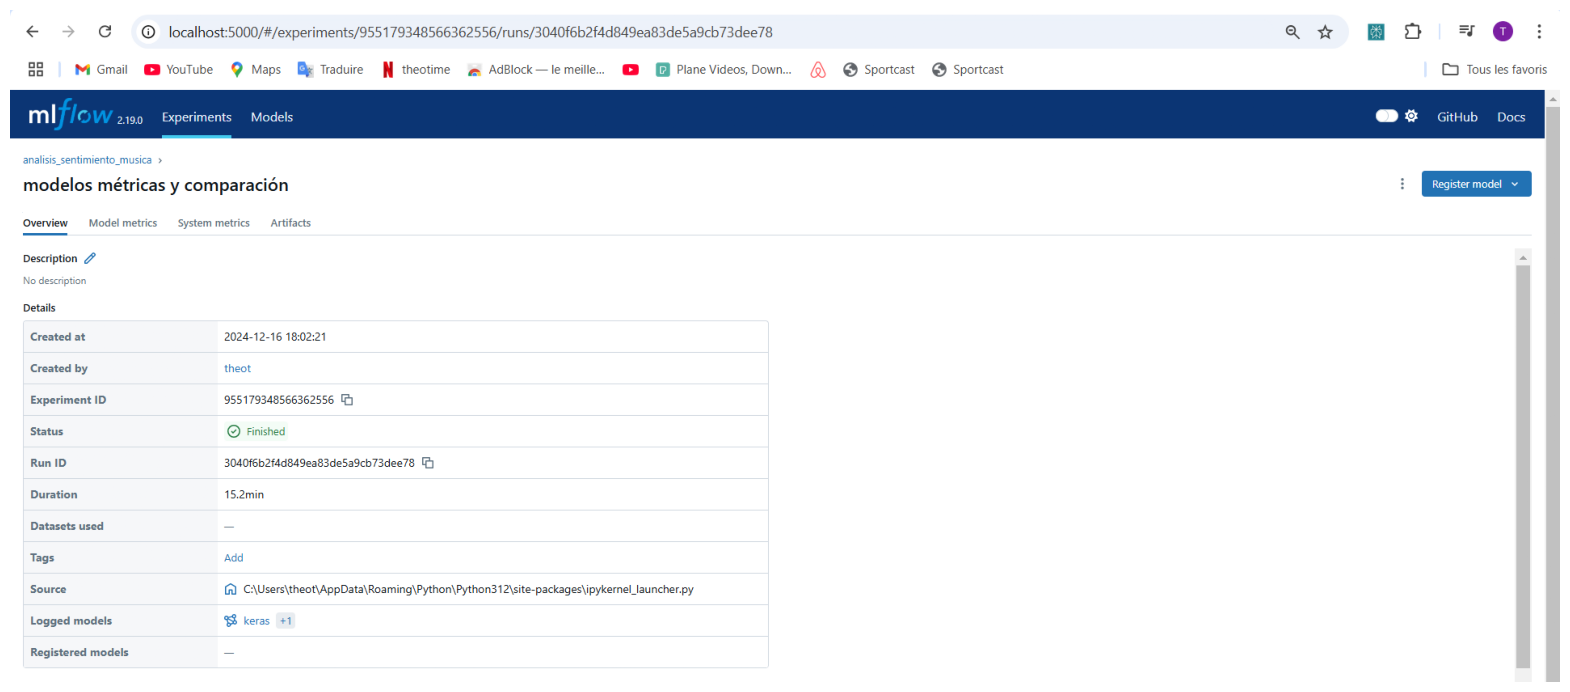

In [58]:
img = mpimg.imread(r'C:\Users\theot\Desktop\Practica despiegle\images\image5.png')

plt.figure(figsize=(20, 16))

plt.imshow(img)
plt.axis('off')
plt.show()

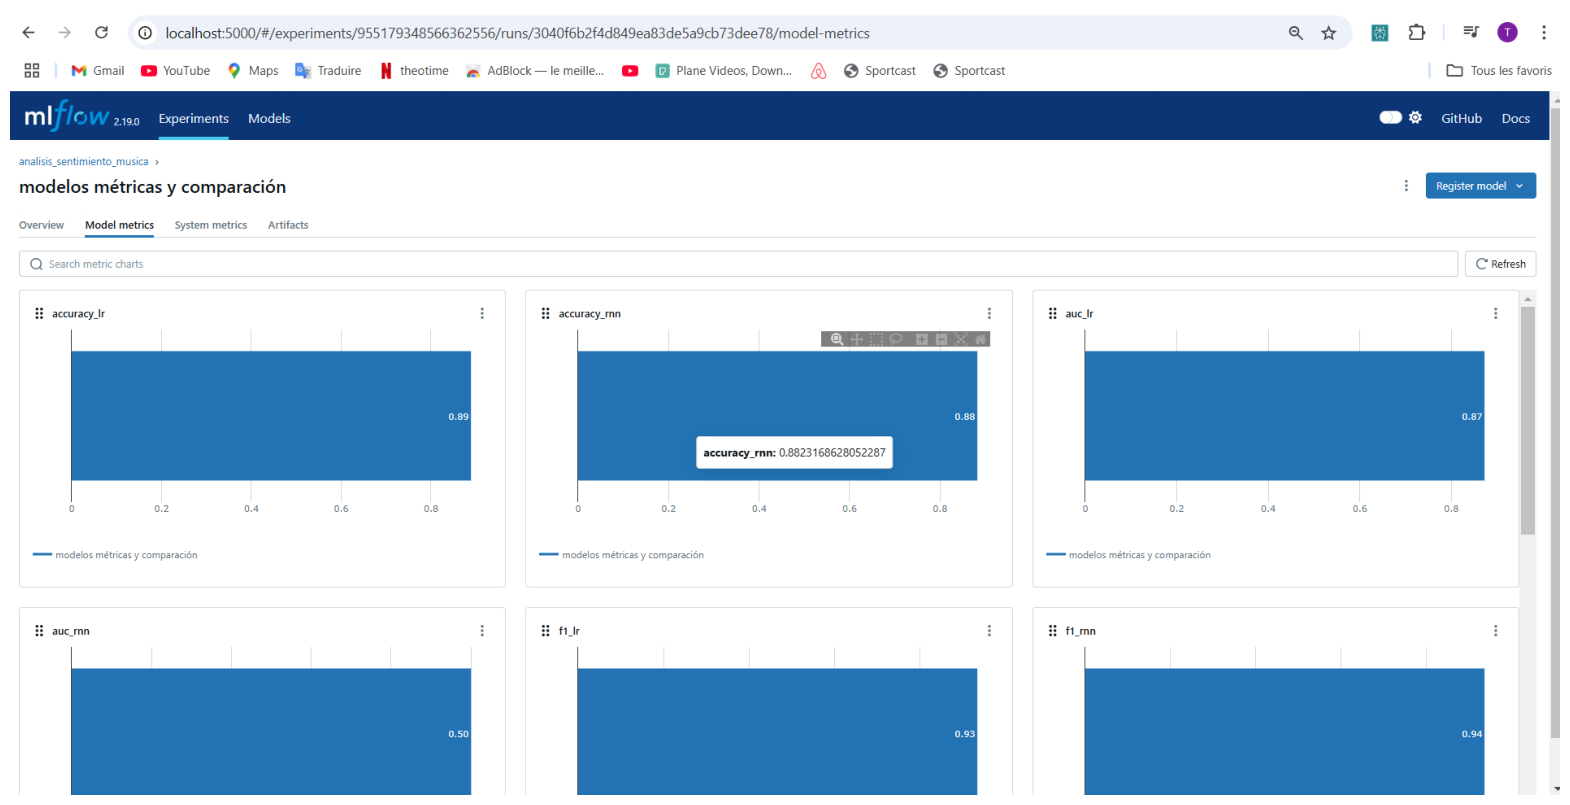

In [59]:
img = mpimg.imread(r'C:\Users\theot\Desktop\Practica despiegle\images\image6.png')

plt.figure(figsize=(20, 16))

plt.imshow(img)
plt.axis('off')
plt.show()

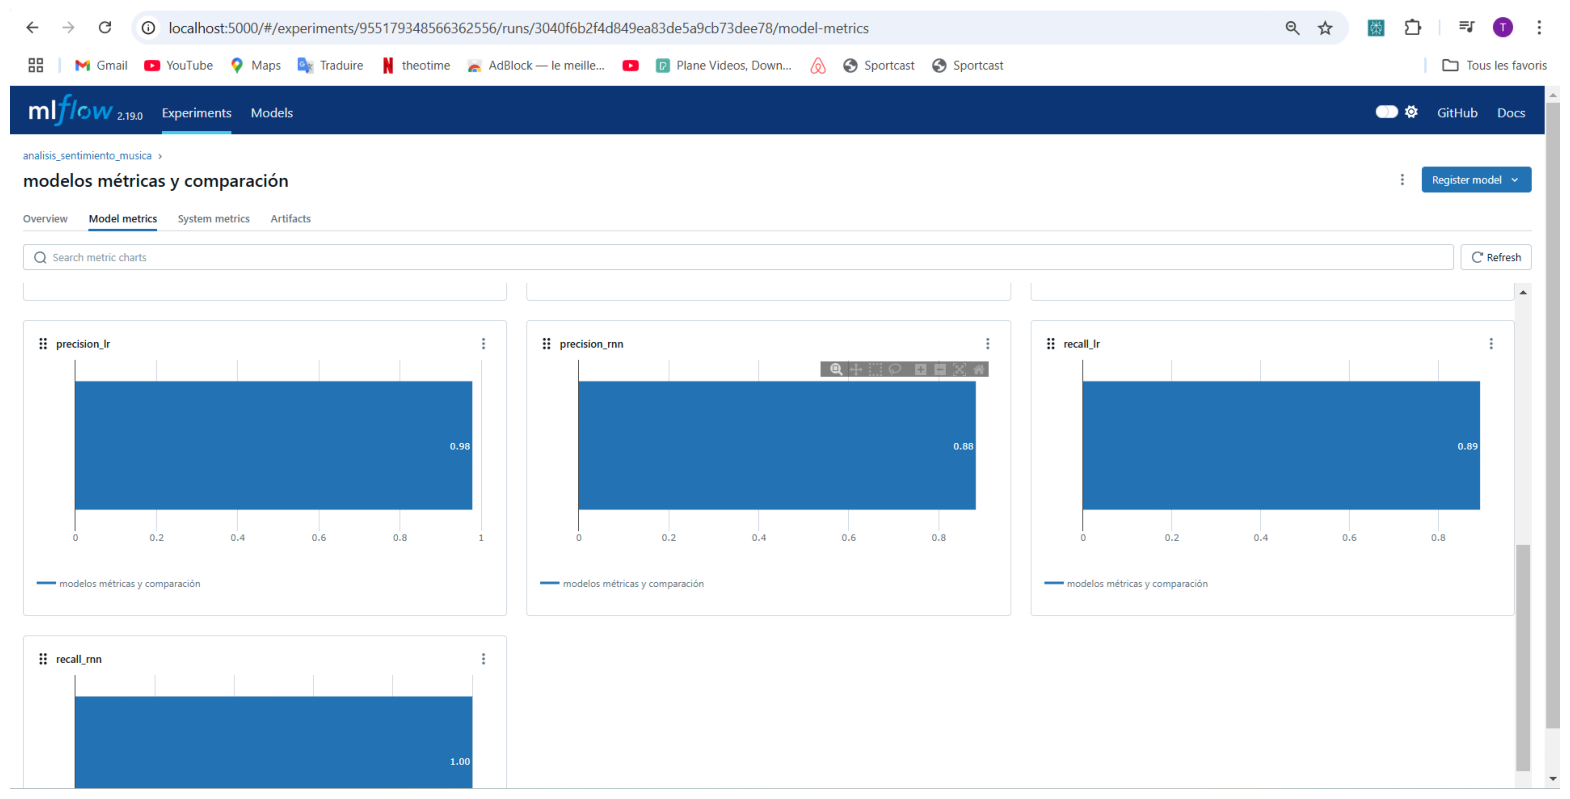

In [60]:
img = mpimg.imread(r'C:\Users\theot\Desktop\Practica despiegle\images\image7.png')

plt.figure(figsize=(20, 16))

plt.imshow(img)
plt.axis('off')
plt.show()